In [1]:
import argparse
import logging
import os
import time

from jax import random
import jax.numpy as jnp

import numpyro
from numpyro.contrib.control_flow import scan
import numpyro.distributions as dist
from numpyro.examples.datasets import JSB_CHORALES, load_dataset
from numpyro.handlers import mask
from numpyro.infer import HMC, MCMC, NUTS, SVI, Trace_ELBO, TraceGraph_ELBO
from numpyro.ops.indexing import Vindex
from numpyro.infer.autoguide import AutoDelta, AutoGuide
from numpyro.optim import Adam
from pyro import poutine

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

rng_key = random.PRNGKey(0)

In [2]:
def model():
    with numpyro.handlers.block(), numpyro.handlers.seed(rng_seed=rng_key):
        a = numpyro.sample('a', dist.Normal(0,1))
    b = numpyro.sample('b', dist.Dirichlet(concentration=jnp.array([2., 3, 4, 5, 6])))

optim = numpyro.optim.Adam(step_size=1e-3)
elbo = Trace_ELBO()
guide = AutoDelta(model)
svi = SVI(model, guide, optim, elbo)
svi_result = svi.run(rng_key, 1000)

100%|██████████| 1000/1000 [00:00<00:00, 1210.06it/s, init loss: -6.3782, avg. loss [951-1000]: -6.5432]


In [3]:
#     x[t-1] --> x[t] --> x[t+1]
#        |        |         |
#        V        V         V
#     y[t-1]     y[t]     y[t+1]
#
# This model includes a plate for the data_dim = 44 keys on the piano. This
# model has two "style" parameters probs_x and probs_y that we'll draw from a
# prior. The latent state is x, and the observed state is y.
def model_1(sequences, lengths, hidden_dim, include_prior=True):
    num_sequences, max_length, data_dim = sequences.shape
    with mask(mask=include_prior):
        probs_x = numpyro.sample(
            "probs_x", dist.Dirichlet(0.9 * jnp.eye(hidden_dim) + 0.1).to_event(1)
        )
        probs_y = numpyro.sample(
            "probs_y",
            dist.Beta(0.1, 0.9).expand([hidden_dim, data_dim]).to_event(2),
        )

    def transition_fn(carry, y):
        x_prev, t = carry
        with numpyro.plate("sequences", num_sequences, dim=-2):
            with mask(mask=(t < lengths)[..., None]):
                with numpyro.handlers.block(), numpyro.handlers.seed(rng_seed=rng_key):
                    x = numpyro.sample(
                        "x",
                        dist.Categorical(probs_x[x_prev]),
                        infer={"enumerate": "parallel"},
                    )
                    with numpyro.plate("tones", data_dim, dim=-1):
                        numpyro.sample("y", dist.Bernoulli(probs_y[x.squeeze(-1)]), obs=y)
        return (x, t + 1), None

    x_init = jnp.zeros((num_sequences, 1), dtype=jnp.int32)
    # NB swapaxes: we move time dimension of `sequences` to the front to scan over it
    scan(transition_fn, (x_init, 0), jnp.swapaxes(sequences, 0, 1))

In [4]:

def main(num_samples=1000, hidden_dim=16, truncate=None, num_sequences=None,
         kernel='nuts', num_warmup=500, num_chains=1, device='cpu'):

    model = model_1
    
    numpyro.set_platform(device)

    _, fetch = load_dataset(JSB_CHORALES, split="train", shuffle=False)
    lengths, sequences = fetch()
    if num_sequences:
        sequences = sequences[0 : num_sequences]
        lengths = lengths[0 : num_sequences]

    logger.info("-" * 40)
    logger.info("Training {} on {} sequences".format(model.__name__, len(sequences)))

    # find all the notes that are present at least once in the training set
    present_notes = (sequences == 1).sum(0).sum(0) > 0
    # remove notes that are never played (we remove 37/88 notes with default args)
    sequences = sequences[:, :, present_notes]

    if truncate:
        lengths = lengths.clip(0, truncate)
        sequences = sequences[:, : truncate]

    logger.info("Each sequence has shape {}".format(sequences[0].shape))
    logger.info("Starting inference...")

    optim = Adam(step_size=1e-3)
    elbo = TraceGraph_ELBO()
    guide = AutoDelta(model)

    svi = SVI(model, guide, optim, loss=elbo)
    start = time.time()
    svi_result = svi.run(rng_key, 25, sequences, lengths, hidden_dim)
    logger.info("\nSVI elapsed time: {}".format(time.time() - start))



In [5]:
main()

INFO:__main__:----------------------------------------
INFO:__main__:Training model_1 on 229 sequences
INFO:__main__:Each sequence has shape (129, 51)
INFO:__main__:Starting inference...
100%|██████████| 25/25 [00:01<00:00, 18.15it/s, init loss: -4447.4497, avg. loss [25-25]: -4470.7266]
INFO:__main__:
SVI elapsed time: 7.64436674118042


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

T = 500
N = 10

phi = 0.9
sigma_x = 0.03
sigma_y = 0.1

np.random.seed(42)

e = np.random.normal(size=T, scale=sigma_x)

x = np.empty(T)

x[0] = e[0]
for t in range(1, T):
    x[t] = x[t - 1] * phi + e[t]
    
y = x + np.random.normal(size=(N, T), scale=sigma_y)

pd.Series(y.mean(0)).plot()
plt.show()
pd.Series(x).plot()
plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [7]:
import jax

def model(y):
    
    N, T = y.shape
    
    phi = numpyro.param('phi', jnp.array(0.0))
    sigma_x = numpyro.param('sigma_x', jnp.array(1.0), constraint=dist.constraints.positive)
    sigma_y = numpyro.param('sigma_y', jnp.array(1.0), constraint=dist.constraints.positive)
    
    def transition(x, e):
        x_new = x * phi + e
        return x_new, x_new
    
    x0 = numpyro.sample('x0', dist.Normal(np.zeros(1), sigma_x))
    e = numpyro.sample('e', dist.Normal(np.zeros(T), sigma_x))
    _, x = jax.lax.scan(transition, x0, e)
    numpyro.deterministic('x', x)
    numpyro.sample('obs', dist.Normal(x.squeeze(-1), sigma_y), obs=y)

y_jax = jnp.array(y)

guide = numpyro.infer.autoguide.AutoNormal(model)
optim = numpyro.optim.Adam(step_size=0.002)
svi = numpyro.infer.SVI(model, guide, optim, loss=numpyro.infer.Trace_ELBO())
svi_result = svi.run(jax.random.PRNGKey(0), 10000, y_jax)

params = svi_result.params
guide_samples = guide.sample_posterior(jax.random.PRNGKey(1), svi_result.params)

print(params['phi'])
print(params['sigma_x'])
print(params['sigma_y'])

100%|██████████| 10000/10000 [00:09<00:00, 1004.66it/s, init loss: 9151.4316, avg. loss [9501-10000]: -4105.5483]


0.573861
0.039156593
0.09995778


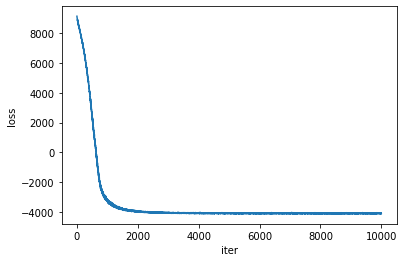

In [8]:
plt.plot(range(len(svi_result.losses)), svi_result.losses)
plt.xlabel('iter')
plt.ylabel('loss')
plt.show()